In [25]:
import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import onnxruntime as ort
import matplotlib.pyplot as plt

from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB

from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence


from helpers import get_data, process_data, display_data

In [26]:
topic_to_index = {
    "tech" : 0,
    "sport" : 1,
    "politics" : 2,
    "gaming" : 3,
    "food" : 4,
    "business" : 5
  }

def map_label_to_class(label):
  try: 
    return topic_to_index[label]
  except: raise ValueError(f"Label '{label}' not found in any source categories.")

def pytorch_to_numpy(loader):
  inputs_array = []
  labels_array = []
  for inputs, labels in loader:
    inputs_batch = inputs.cpu().numpy()
    labels_batch = labels.cpu().numpy()

    for input in inputs_batch:
      inputs_array.append(input)
    for label in labels_batch:
      labels_array.append(label)
  return inputs_array, labels_array

In [27]:
# dataset initialization
class TopicData(Dataset):
  def __init__(self,df,device):
    df.drop(columns=['id'])
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    self.data = df
    self.device = device
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    text = self.data['text'][idx]
    label = map_label_to_class(self.data['topic'][idx])
    vectorized_text = self.tokenizer(
      text,
      return_tensors='pt',
      truncation=True,
      )
    input = vectorized_text['input_ids'].squeeze(0)
    return input.to(self.device),torch.tensor(label).to(self.device)

In [28]:
# split data 
def collate_fn(batch):
  inputs, labels = zip(*batch)
  inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
  labels = torch.stack(labels)
  return inputs, labels

def split_data(dataset,batch_size):
  train_idx, test_idx = train_test_split(range(len(dataset)),test_size=0.2,random_state=42,shuffle=True)
  train_dataset = Subset(dataset,train_idx)
  test_dataset = Subset(dataset,test_idx)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  return train_loader, test_loader

In [29]:
# model
class TopicClassificationModel(nn.Module):
  def __init__(self,input_size,embed_dim,hidden_dim_1,num_class):
    super(TopicClassificationModel,self).__init__()
    self.embed = nn.EmbeddingBag(input_size,embed_dim)
    self.fc1 = nn.Linear(embed_dim, hidden_dim_1)
    self.fc2 = nn.Linear(hidden_dim_1, num_class)
    self.relu = nn.LeakyReLU()
  
  def forward(self,text):
    embed = self.embed(text)
    output = self.relu(self.fc1(embed))
    output = self.fc2(output)
    return F.softmax(output,dim=1)

In [30]:
# train and test
def train(dataloader,model,optimizer,criterion,verbose):
  model.train()
  train_loss = 0
  train_acc = 0
  total_samples = 0

  for text,label in tqdm(dataloader, disable=not verbose):
    optimizer.zero_grad()
    
    output = model(text)
    loss = criterion(output,label)

    train_loss += loss.item()
    train_acc += (output.argmax(1) == label).sum().item()
    total_samples += text.size(0)

    loss.backward()
    optimizer.step()

  train_loss/=total_samples
  train_acc/=total_samples

  return train_loss, train_acc, model, optimizer, criterion

def test(dataloader,model,criterion, verbose):
  model.eval()
  test_loss = 0
  test_acc = 0
  total_samples = 0
  test_preds = []
  test_labels = []

  with torch.no_grad():
    for text,label in tqdm(dataloader,disable=not verbose):
      output = model(text)
      loss = criterion(output,label)
      test_loss += loss.item()
      test_acc += (output.argmax(1) == label).sum().item()
      total_samples += text.size(0)

      test_preds.extend(output.argmax(1).cpu().numpy())
      test_labels.extend(label.cpu().numpy())
      
  test_loss/=total_samples
  test_acc/=total_samples
  return test_loss,test_acc, test_preds, test_labels

def train_test_loop(path,device,train_loader,test_loader,num_epochs,model,optimizer,criterion,verbose):
  print('Training Classification NN Starting')

  train_losses = []
  train_accs = []
  test_losses = []
  test_accs = []
  for epoch in range(num_epochs):
    train_loss, train_acc, model, optimizer, criterion = train(train_loader,model,optimizer,criterion,verbose)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    if verbose: print(f'Training Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')

    test_loss, test_acc, test_preds, test_labels  = test(test_loader,model,criterion,verbose)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    if verbose: print(f'Test Epoch [{epoch + 1}/{num_epochs}], Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}')
  
  
  model.eval()
  input, _ = next(iter(test_loader))
  dummy_input = torch.randint(low=0,high=1,size=(1, input.shape[1]), dtype=torch.int32).to(device)
  torch.onnx.export(
    model,
    dummy_input,
    path,
    export_params=True,
    opset_version=16,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes = {
      'input' : {0: 'batch_size', 1: 'sequence_length'},
      'output' : {0: 'batch_size'}
    }
  )
  

  print('Model Saved - Training Done, Final Testing Results Are As Shown:')
  print(f'Training Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')
  print(f'Test Epoch [{epoch + 1}/{num_epochs}], Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}')

  plt.plot(train_losses,label='Train Loss')
  plt.plot(test_losses,label='Test Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.plot(train_accs,label='Train Acc')
  plt.plot(test_accs,label='Test Acc')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy %')
  plt.legend()
  plt.show()

  cm = confusion_matrix(test_labels, test_preds)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
  disp.plot(cmap='Blues')
  plt.title('Confusion Matrix: Predicted vs Actual Labels')
  plt.show()

  return model

In [31]:
# predict
'''def predict_text(text,session,dataset):
  text = process_text(text)
  vectorized_text = dataset.tokenizer(
      text,
      return_tensors='np',
      truncation=True,
      )
  onnx_input = {
    'input' : vectorized_text['input_ids'].astype(np.int32)
  }
  output = session.run(None,onnx_input)[0][0]
  prediction = output.argmax()

  label_map = {0: 'left', 1: 'right', 2: 'center'}
  prediction = label_map.get(prediction, 'Prediction error.')
  probabilities_percentage = [f"{p * 100:.1f}%" for p in output]

  print(f'The text provided leans towards {prediction} with a probability of '
          f'{probabilities_percentage[0]} for left, {probabilities_percentage[1]} for right, and '
          f'{probabilities_percentage[2]} for center.')'''

'def predict_text(text,session,dataset):\n  text = process_text(text)\n  vectorized_text = dataset.tokenizer(\n      text,\n      return_tensors=\'np\',\n      truncation=True,\n      )\n  onnx_input = {\n    \'input\' : vectorized_text[\'input_ids\'].astype(np.int32)\n  }\n  output = session.run(None,onnx_input)[0][0]\n  prediction = output.argmax()\n\n  label_map = {0: \'left\', 1: \'right\', 2: \'center\'}\n  prediction = label_map.get(prediction, \'Prediction error.\')\n  probabilities_percentage = [f"{p * 100:.1f}%" for p in output]\n\n  print(f\'The text provided leans towards {prediction} with a probability of \'\n          f\'{probabilities_percentage[0]} for left, {probabilities_percentage[1]} for right, and \'\n          f\'{probabilities_percentage[2]} for center.\')'

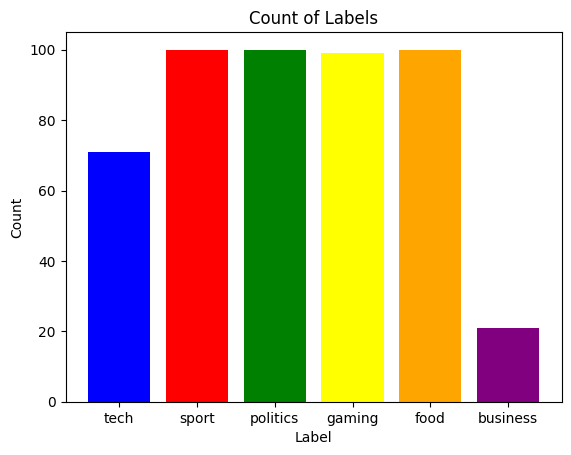

cuda
Training Classification NN Starting


100%|██████████| 40/40 [00:00<00:00, 53.09it/s]


Training Epoch [1/10], Loss: 0.1803, Accuracy: 0.2219


100%|██████████| 10/10 [00:00<00:00, 186.21it/s]


Test Epoch [1/10], Loss: 0.1799, Accuracy: 0.1818


100%|██████████| 40/40 [00:00<00:00, 95.08it/s]


Training Epoch [2/10], Loss: 0.1789, Accuracy: 0.2551


100%|██████████| 10/10 [00:00<00:00, 171.55it/s]


Test Epoch [2/10], Loss: 0.1803, Accuracy: 0.2323


100%|██████████| 40/40 [00:00<00:00, 93.63it/s]


Training Epoch [3/10], Loss: 0.1782, Accuracy: 0.3061


100%|██████████| 10/10 [00:00<00:00, 195.11it/s]


Test Epoch [3/10], Loss: 0.1804, Accuracy: 0.2121


100%|██████████| 40/40 [00:00<00:00, 96.60it/s]


Training Epoch [4/10], Loss: 0.1764, Accuracy: 0.3214


100%|██████████| 10/10 [00:00<00:00, 174.11it/s]


Test Epoch [4/10], Loss: 0.1798, Accuracy: 0.2121


100%|██████████| 40/40 [00:00<00:00, 97.64it/s]


Training Epoch [5/10], Loss: 0.1758, Accuracy: 0.3061


100%|██████████| 10/10 [00:00<00:00, 185.48it/s]


Test Epoch [5/10], Loss: 0.1778, Accuracy: 0.2424


100%|██████████| 40/40 [00:00<00:00, 93.93it/s]


Training Epoch [6/10], Loss: 0.1707, Accuracy: 0.3852


100%|██████████| 10/10 [00:00<00:00, 171.19it/s]


Test Epoch [6/10], Loss: 0.1790, Accuracy: 0.2121


100%|██████████| 40/40 [00:00<00:00, 97.64it/s]


Training Epoch [7/10], Loss: 0.1689, Accuracy: 0.3878


100%|██████████| 10/10 [00:00<00:00, 183.10it/s]


Test Epoch [7/10], Loss: 0.1765, Accuracy: 0.2626


100%|██████████| 40/40 [00:00<00:00, 97.69it/s]


Training Epoch [8/10], Loss: 0.1635, Accuracy: 0.4617


100%|██████████| 10/10 [00:00<00:00, 186.87it/s]


Test Epoch [8/10], Loss: 0.1746, Accuracy: 0.2626


100%|██████████| 40/40 [00:00<00:00, 93.64it/s]


Training Epoch [9/10], Loss: 0.1619, Accuracy: 0.5051


100%|██████████| 10/10 [00:00<00:00, 179.01it/s]


Test Epoch [9/10], Loss: 0.1745, Accuracy: 0.3131


100%|██████████| 40/40 [00:00<00:00, 95.35it/s]


Training Epoch [10/10], Loss: 0.1570, Accuracy: 0.5357


100%|██████████| 10/10 [00:00<00:00, 170.53it/s]


Test Epoch [10/10], Loss: 0.1710, Accuracy: 0.3535
Model Saved - Training Done, Final Testing Results Are As Shown:
Training Epoch [10/10], Loss: 0.1570, Accuracy: 0.5357
Test Epoch [10/10], Loss: 0.1710, Accuracy: 0.3535


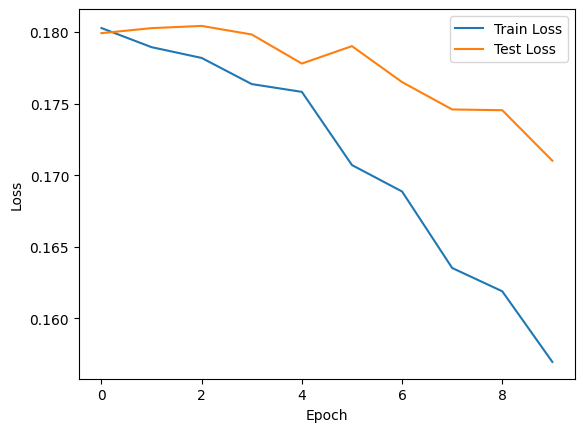

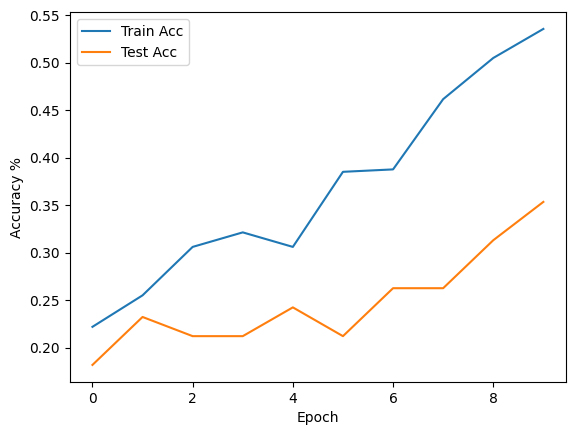

ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of labels (3).

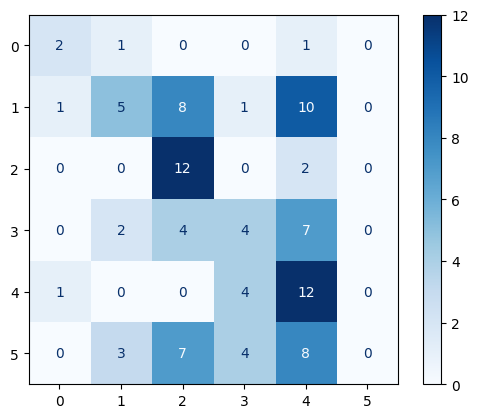

In [32]:
def main(text, batch_size, num_epochs, verbose, override, skl):
  device = ('cuda' if torch.cuda.is_available() else 'cpu')

  nn_path = '../models/topic_model.onnx'
  
  df = get_data()
  df = process_data(df)

  if (override or not os.path.exists(nn_path) and verbose):
    display_data(df)
    print(device)

  dataset = TopicData(df,device)
  train_loader, test_loader = split_data(dataset,batch_size)
  if skl: 
    batch_size = len(df)
    inputs_array, labels_array = pytorch_to_numpy(train_loader)
    test_inputs_array, test_label_array = pytorch_to_numpy(test_loader)
    gnb = GaussianNB()
    model = gnb.fit(inputs_array,labels_array)
    pred = model.predict(test_inputs_array)
    print("Number of mislabeled points out of a total %d points : %d"
        % (len(test_inputs_array), (test_label_array != pred).sum()))
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
  else:
    input_size = dataset.tokenizer.vocab_size
    embed_dim = 256
    hidden_dim_1 = 64
    num_classes = len(topic_to_index)
    model = TopicClassificationModel(input_size,embed_dim,hidden_dim_1,num_classes).to(device)
    if(override or not os.path.exists(nn_path)):
      optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-5)
      criterion = torch.nn.CrossEntropyLoss()
      train_test_loop(nn_path,device,train_loader,test_loader,num_epochs,model,optimizer,criterion,verbose)  

  session = ort.InferenceSession(nn_path)
  
main('sports sports sports', batch_size=10, num_epochs=10, verbose=True, override=True, skl=False)